In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from google.colab import drive

# 1. MOUNT DRIVE
drive.mount('/content/drive')

# 2. LOCAL SSD COPY (The "Unit Saver")
# This moves 20,000+ images from Drive to the fast local SSD
drive_image_dir = "/content/drive/MyDrive/Beetle Vision/extracted_beetles/extracted_beetles/"
local_image_dir = "/content/beetle_images/"

if not os.path.exists(local_image_dir):
    print("Copying images to local SSD for maximum speed...")
    shutil.copytree(drive_image_dir, local_image_dir, dirs_exist_ok=True)
    print("Copy complete!")
else:
    print("Images already on local SSD.")

# Set the ROOT_DIR to the local folder
ROOT_DIR = local_image_dir

# 3. LOAD DATA
print("Loading CSV files...")
full_df = pd.read_csv("/content/drive/MyDrive/Beetle Vision/extracted_beetles/train.csv")
train_df, local_val_df = train_test_split(full_df, test_size=0.2, random_state=42)

print(f"Training on {len(train_df)} images. Validating on {len(local_val_df)} images.")

# 4. PREPROCESSING FUNCTIONS
IMG_SIZE = 260

def process_image(image_path, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) # EfficientNetV2 likes [0-255]
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def get_multi_input_train(image_path, name, domain, label):
    return (process_image(image_path, augment=True), name, domain), label

def get_multi_input_valid(image_path, name, domain, label):
    return (process_image(image_path, augment=False), name, domain), label

def create_data_batches(df, batch_size=64, valid_data=False):
    # Uses the LOCAL ROOT_DIR
    paths = [ROOT_DIR + fname for fname in df['relative_img_loc']]
    names = df['scientificName'].values.astype(str)
    domains = df['domainID'].values.astype(str)
    labels = df[["SPEI_30d", "SPEI_1y", "SPEI_2y"]].values.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((paths, names, domains, labels))

    if valid_data:
        dataset = dataset.map(get_multi_input_valid, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
    else:
        dataset = dataset.shuffle(buffer_size=len(df)).map(get_multi_input_train, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

    return dataset.prefetch(tf.data.AUTOTUNE)

# 5. CREATE DATASETS
train_data = create_data_batches(train_df, batch_size=32, valid_data=False)
val_data = create_data_batches(local_val_df, batch_size=32, valid_data=True)

# 6. BUILD MODEL ARCHITECTURE
names_vocab = full_df['scientificName'].astype(str).unique()
domain_vocab = full_df['domainID'].astype(str).unique()

name_layer = layers.StringLookup(vocabulary=names_vocab, output_mode='one_hot')
domain_layer = layers.StringLookup(vocabulary=domain_vocab, output_mode='one_hot')

def create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), output_shape=3):
    img_input = tf.keras.Input(shape=input_shape, name="img_input")
    name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name="name_input")
    domain_input = tf.keras.Input(shape=(1,), dtype=tf.string, name="domain_input")

    base_model = tf.keras.applications.EfficientNetV2B2(include_top=False, weights='imagenet')
    base_model.trainable = True

    x1 = base_model(img_input)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x1 = layers.Dense(256, activation='relu')(x1)
    x1 = layers.Dropout(0.3)(x1)

    x2 = layers.concatenate([name_layer(name_input), domain_layer(domain_input)])
    x2 = layers.Dense(64, activation='relu')(x2)

    combined = layers.concatenate([x1, x2])
    z = layers.Dense(128, activation='relu')(combined)
    outputs = layers.Dense(output_shape, activation='linear')(z)

    model = tf.keras.Model(inputs=[img_input, name_input, domain_input], outputs=outputs)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["mae"])
    return model

# 7. TRAIN WITH CALLBACKS
# 1. Instantiate the Model
import os

# 7. TRAIN WITH CALLBACKS (RESUME MODE)
save_path = "/content/drive/MyDrive/Beetle Vision/best_beetle_model.keras"

if os.path.exists(save_path):
    print("Found saved model! Resuming training from where we left off...")
    model = tf.keras.models.load_model(save_path)
else:
    print("⚠️ No saved model found. Starting fresh...")
    model = create_model()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path, save_best_only=True, monitor="val_loss", mode="min", verbose=1
)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

print("Resuming Training on L4 GPU...")
history = model.fit(
    train_data, validation_data=val_data,
    epochs=150, callbacks=[checkpoint_cb, early_stop_cb]
)

# 8. FINAL EVALUATION & PREDICTIONS
print("Evaluating on Validation Set...")
test_csv = pd.read_csv("/content/drive/MyDrive/Beetle Vision/extracted_beetles/val.csv")
final_exam_data = create_data_batches(test_csv, batch_size=32, valid_data=True)

predictions = model.predict(final_exam_data)

# Save Results
results_df = pd.DataFrame({
    'public_id': test_csv['public_id'],
    'Real_30d': test_csv['SPEI_30d'], 'Pred_30d': predictions[:, 0],
    'Real_1y': test_csv['SPEI_1y'], 'Pred_1y': predictions[:, 1],
    'Real_2y': test_csv['SPEI_2y'], 'Pred_2y': predictions[:, 2]
})
results_df.to_csv("/content/drive/MyDrive/Beetle Vision/beetle_predictions.csv", index=False)

print("Saved all predictions to 'beetle_predictions.csv'")

Mounted at /content/drive
📦 Copying images to local SSD for maximum speed...
✅ Copy complete!
📂 Loading CSV files...
Training on 17896 images. Validating on 4474 images.
✅ Found saved model! Resuming training from where we left off...
🚀 Resuming Training on L4 GPU...
Epoch 1/150
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.2332 - mae: 0.2332
Epoch 1: val_loss improved from inf to 0.43730, saving model to /content/drive/MyDrive/Beetle Vision/best_beetle_model.keras
560/560 ━━━━━━━━━━━━━━━━━━━━ 216s 292ms/step - loss: 0.2332 - mae: 0.2332 - val_loss: 0.4373 - val_mae: 0.4373
Epoch 2/150
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.2269 - mae: 0.2269
Epoch 2: val_loss improved from 0.43730 to 0.42810, saving model to /content/drive/MyDrive/Beetle Vision/best_beetle_model.keras
560/560 ━━━━━━━━━━━━━━━━━━━━ 160s 286ms/step - loss: 0.2269 - mae: 0.2269 - val_loss: 0.4281 - val_mae: 0.4281
Epoch 3/150
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.2206 - mae: 0.2206
Epoc

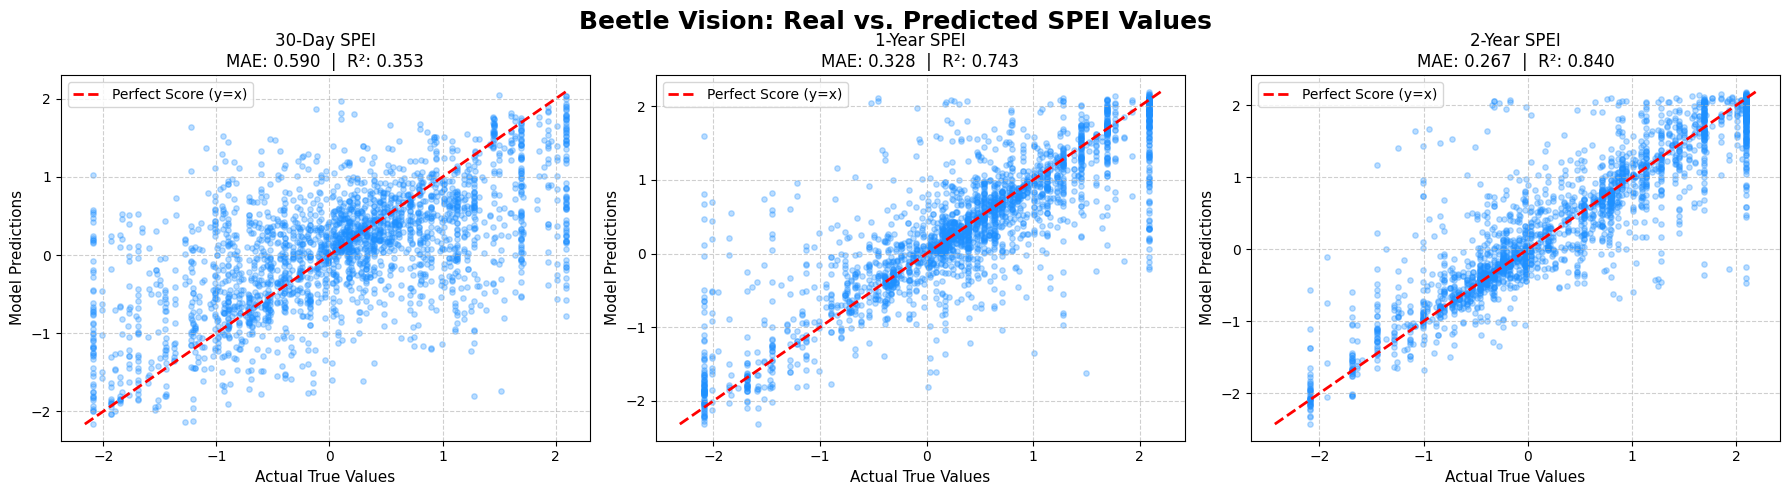

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Load your newly minted predictions!
file_path = "/content/drive/MyDrive/Beetle Vision/beetle_predictions.csv"
df = pd.read_csv(file_path)

# 2. Set up the figure canvas (3 separate graphs side-by-side)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Beetle Vision: Real vs. Predicted SPEI Values', fontsize=18, fontweight='bold')

# These are the column names from your CSV
targets = [
    ('Real_30d', 'Pred_30d', '30-Day SPEI'),
    ('Real_1y', 'Pred_1y', '1-Year SPEI'),
    ('Real_2y', 'Pred_2y', '2-Year SPEI')
]

# 3. Loop through and draw each graph
for i, (real_col, pred_col, title) in enumerate(targets):
    ax = axes[i]

    # Grab the data columns
    y_true = df[real_col]
    y_pred = df[pred_col]

    # Calculate extra accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Draw the scatter plot dots
    ax.scatter(y_true, y_pred, alpha=0.3, color='dodgerblue', s=15)

    # Draw the Red "Perfect Prediction" Line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Score (y=x)')

    # Formatting
    ax.set_title(f'{title}\nMAE: {mae:.3f}  |  R²: {r2:.3f}', fontsize=12)
    ax.set_xlabel('Actual True Values', fontsize=11)
    ax.set_ylabel('Model Predictions', fontsize=11)
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(top=0.85) # Gives the main title room to breathe
plt.show()